# Crawler

In [211]:
import requests

In [212]:
imo_base_url = "https://www.imo-official.org/"

In [213]:
def connect_to_webpage(year):
    r = requests.get(
        'http://www.imo-official.org/year_info.aspx?year=' + str(year),
        allow_redirects=True)
    return str(r.content)

In [214]:
def extract_stats_of_webpage(content):
    stats = []
    index = 0
    for _ in range(3):
        index += content[index:].find('(score &ge; ')
        stats.append(int(content[index + 12: index + 18].split()[0]))
        index += 1
    gold = stats[0] - 1
    silver = stats[1] - 1
    bronze = stats[2] - 1
    return gold, silver, bronze

In [215]:
def fetch_scores_and_medals(year_start, year_end):
    years = []
    gold_scores = []
    silver_scores = []
    bronze_scores = []
    for year in range(year_start, year_end + 1):
        content = connect_to_webpage(year)
        years.append(year)
        gold, silver, bronze = extract_stats_of_webpage(content)
        gold_scores.append(gold)
        silver_scores.append(silver)
        bronze_scores.append(bronze)
    return years, gold_scores, silver_scores, bronze_scores

In [216]:
def fetch_scores_compressed(year_start, year_end):
    years, golds, silvers, bronzes = fetch_scores_and_medals(year_start, year_end)
    return [(years[i], [bronzes[i], silvers[i], golds[i]]) for i in range(len(years))]

In [217]:
def fetch_and_save(year_start, year_end, path):
    years, golds, silvers, bronzes = fetch_scores_and_medals(year_start, year_end)
    with open(path, 'w') as f:
        for i in range(len(years)):
            f.write(','.join(map(str, [years[i], golds[i], silvers[i], bronzes[i]])))
            f.write('\n')

In [218]:
fetch_and_save(2017, 2018, 'test.csv')

# Plotter

In [219]:
import matplotlib.pyplot as plt
import random
import numpy as np

In [220]:
colors = dict()
colors['gold'] = (255 / 255, 223 / 255, 0 / 255)
colors['silver'] = (208 / 255, 210 / 255, 209 / 255)
colors['bronze'] = (128 / 255, 74 / 255, 0 / 255)

colors['gold_marker'] = 'orange'
colors['silver_marker'] = (25 / 255, 81 / 255, 144 / 255)
colors['bronze_marker'] = 'purple'

red_color = (255 / 255, 0 / 255, 0 / 255)
colors['gold_trend'] = tuple(map(np.mean, zip(red_color, red_color, colors['gold'])))
colors['silver_trend'] = tuple(map(np.mean, zip(red_color, red_color, colors['silver'])))
colors['bronze_trend'] = tuple(map(np.mean, zip(red_color, red_color, colors['bronze'])))

In [221]:
# scores_by_year is a list of tuples like (year, [bronze_min, silver_min, gold_min])
def plot_scores_by_year(scores_by_year, colors=colors, trend_poly_degree=2):
    years = []
    bronze_mins = []
    silver_mins = []
    gold_mins = []
    
    minimum_possible = []
    maximum_possible = []
    
    for year, mins_list in scores_by_year:
        years.append(year)
        
        b_min, s_min, g_min = mins_list[0], mins_list[1], mins_list[2]
        bronze_mins.append(b_min + 1)
        silver_mins.append(s_min + 1)
        gold_mins.append(g_min + 1)
        
        maximum_possible.append(42)
        minimum_possible.append(0)
    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_yticks([0, 7, 14, 21, 28, 35, 42])
    ax.set_xticks(years)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
        
    ax.set_title("IMO Cutoffs by Year", size=20)
    
    # Line plots
    ax.plot(years, maximum_possible, color='gold')
    ax.plot(years, gold_mins, marker='s', color=colors['gold'], mfc=colors['gold_marker'])
    ax.plot(years, silver_mins, marker='D', color=colors['silver'], mfc=colors['silver_marker'])
    ax.plot(years, bronze_mins, marker='o', color=colors['bronze'], mfc=colors['bronze_marker'])    
    ax.plot(years, minimum_possible, color='w')    
    
    # Filling the gaps in between
    ax.fill_between(years, gold_mins, maximum_possible, alpha=0.2, color=colors['gold'])
    ax.fill_between(years, silver_mins, gold_mins, alpha=0.2, color=colors['silver'])
    ax.fill_between(years, bronze_mins, silver_mins, alpha=0.2, color=colors['bronze'])
    
    # Trendlines
    gold_poly_fit = np.poly1d(np.polyfit(years, gold_mins, trend_poly_degree))
    silver_poly_fit = np.poly1d(np.polyfit(years, silver_mins, trend_poly_degree))
    bronze_poly_fit = np.poly1d(np.polyfit(years, bronze_mins, trend_poly_degree))
    ax.plot(years, gold_poly_fit(years), linestyle='--', color=colors['gold_trend'])
    ax.plot(years, silver_poly_fit(years), linestyle='--', color=colors['silver_trend'])
    ax.plot(years, bronze_poly_fit(years), linestyle='--', color=colors['bronze_trend'])
    
    
    plt.show()

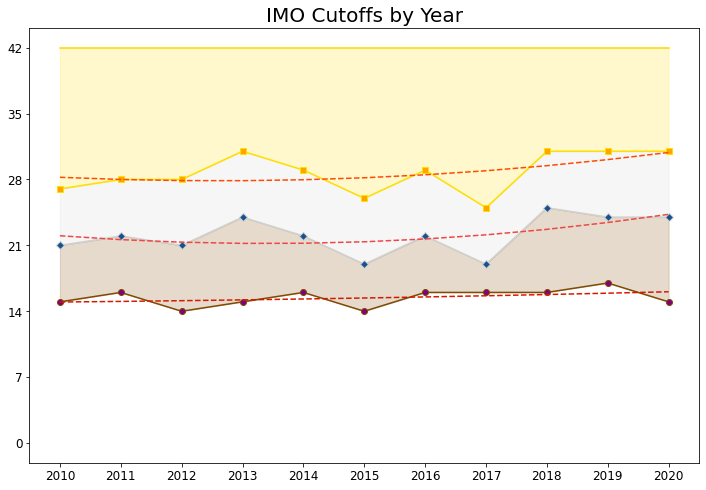

In [223]:
temp_scores_by_year = fetch_scores_compressed(2010, 2020)
plot_scores_by_year(temp_scores_by_year)